# **Step 2:** Using a Trained <nobr>Micro$\mathbb{S}$plit</nobr> Model

# Introduction - what does this notebook do?
In this notebook, we will learn how to use a previously trained <nobr>Micro$\mathbb{S}$plit</nobr> model to unmix superimposed cellular structures in fluorescent microscopy data. For this, we will use a held-out portion of the *HT_H24* dataset, which we have not used during training.

**More specifically we will:**
* make full frame predictions and inspect the results,
* explore the possibility of <nobr>Micro$\mathbb{S}$plit</nobr> to sample predictions from the learned posterior of possible solutions,
* visually inspect the data uncertainty we can deduce from posterior samples, and
* quantitatively evaluate the model using several metrics. 

# Let's do it, let's use <nobr>Micro$\mathbb{S}$plit</nobr>!

**You are new to Jupyter notebooks?** Don't worry, if you take the time to read all our explanations, we will guide you through them and you will understand a lot. Still, you will likely end up less frustrated, if you do not even start with the ambition to interpret the purpose of every line of code.
Let's start with a nice example, the imports to enable the remainder of this notebook. Ignore it (unless you know what you are doing) and just click **⇧*Shift* + ⏎*Enter*** to execute this (and all other) code cells. 

In [1]:
import os
import platform
import copy
import pooch
import tifffile
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.utils.io import load_checkpoint_path
from microsplit_reproducibility.utils.utils import (
    plot_input_patches_3d,
    plot_individual_samples,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions,
    plot_error,
    get_single_file_predictions,
)
from careamics.utils.metrics import avg_range_invariant_psnr, avg_ssim

# Dataset specific imports...
from microsplit_reproducibility.configs.parameters.HT_H24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_H24 import get_data_configs
from microsplit_reproducibility.datasets.HT_H24 import get_train_val_data

In [2]:
from rich import pretty, print
from rich.console import Console
pretty.install()
console = Console(color_system="windows")

# **Step 2.1:** Data Preparation

### Download the data
Depending on your internet connection, this will take a while...

Appropriate noise models will only be downloaded if they were not created by executing the notebook `00_noisemodels.ipynb`.

In [3]:
DATA = pooch.create(
    path="/group/jug/aman/Datasets/HT_H24/data",
    base_url="https://download.fht.org/jug/msplit/ht_h24/data",
    registry={f"ht_h24.zip": None},
)

NOISE_MODELS = pooch.create(
    path=f"/group/jug/aman/Datasets/HT_H24/noise_models/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h24/noise_models/",
    registry={
        f"noise_model_Ch0.npz": None,
        f"noise_model_Ch1.npz": None,
    },
)

In [4]:
for fname in NOISE_MODELS.registry:
    NOISE_MODELS.fetch(fname, progressbar=True)
print('---------')
for fname in DATA.registry:
    DATA.fetch(fname, processor=pooch.Unzip(), progressbar=True)

---------

### Next, we load the data we selected above...

In [5]:
# setting up train, validation, and test data configs
train_data_config, val_data_config, test_data_config = get_data_configs(sliding_window_flag = True)
# setting up MicroSplit parametrization
experiment_params = get_microsplit_parameters(nm_path=NOISE_MODELS.path, batch_size=32)

# start the download of required files
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / f"ht_h24.zip.unzip/ht_h24",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Dataclass is <class 'careamics.lvae_training.dataset.windowed_tiling_dataset.WindowedTilingDloader'>
Loading from /group/jug/aman/Datasets/HT_H24/data/ht_h24.zip.unzip/ht_h24/WTC11_WT_DIV25_3_1_0001.nd2
train_idx [ 2  1  9  0  8  5 12 10 15 11  4 13  3]

Padding is not used with this alignement style
From inside set_img_sz of WindowedTilingDloader:
[WindowedTilingDloader] Data Size (13, 15, 1608, 1608, 2)
[WindowedTilingDloader] Image size (patch size): 64
[WindowedTilingDloader] Grid size: (9, 32, 32)
[WindowedTilingDloader] Using stride spatial: [9, 4, 4]
[WindowedTilingDloader] Padding data from (13, 15, 1608, 1608, 2) to (13, 18, 1608, 1608, 2)
[WindowedTilingDloader] pad_width: [(0, 0), (1, 2), (0, 0), (0, 0), (0, 0)]
[WindowedTilingDloader] Padded data shape: (13, 18, 1608, 1608, 2)

[WindowedTilingDloader] Padded data shape: (13, 18, 1608, 1608, 2), with padding of [3, 0, 0] on each edge thus [3, 0, 0, 3, 0, 0] in total
[WindowedTilingDloader] Padded noise data shape: None
Windo

### Configure `num_workers`
In Windows and MacOS, setting `num_workers > 0` for dataloaders would cause out-of-memory issue and might crash the system.

In [6]:
def get_num_workers():
    """Utility function to set num_workers based on OS."""
    if platform.system() == "Windows" or platform.system() == "Darwin":
        return 0
    else:
        return 3  # or any other number suitable for your system

experiment_params["num_workers"] = get_num_workers()

### 👇 🖼️ pick Validation or Test data to be used! 👇
**Side Note:** if you want to be well prepared for the next notebook on calibration and error estimation, you will have to do both (ie, after you have run this notebook with <i> evaluate_on_validation_data = False </i> in the cell below, return here, set <i> evaluate_on_validation_data = True </i> and re-run the subsequent cells). This will ensure that the files required in the next notebook for both the test and validation datasets are prepared correctly. More detail is provided in section 2.7


In [7]:
# by default, we will use the held out test data, 
# but if you want, we can switch to using the 
# validation data instead
evaluate_on_validation_data = False
if evaluate_on_validation_data:
    print('Will use validation data',end='')
    dset = val_dset
else:
    print('Will use test data',end='')
    dset = test_dset
print(f' (containing a total of {dset.get_num_frames()} frames).')

Will use test data

(containing a total of 2 frames).

### Finally, let's look at bits of the data you chose!


From inside set_img_sz of WindowedTilingDloader:
[WindowedTilingDloader] Data Size (2, 15, 1608, 1608, 2)
[WindowedTilingDloader] Image size (patch size): 128
[WindowedTilingDloader] Grid size: (9, 32, 32)
[WindowedTilingDloader] Using stride spatial: [9, 4, 4]
[WindowedTilingDloader] Padding data from (2, 15, 1608, 1608, 2) to (2, 18, 1608, 1608, 2)
[WindowedTilingDloader] pad_width: [(0, 0), (1, 2), (0, 0), (0, 0), (0, 0)]
[WindowedTilingDloader] Padded data shape: (2, 18, 1608, 1608, 2)

[WindowedTilingDloader] Padded data shape: (2, 18, 1608, 1608, 2), with padding of [3, 0, 0] on each edge thus [3, 0, 0, 3, 0, 0] in total
[WindowedTilingDloader] Padded noise data shape: None
WindowedTilingGridIndexManager initialized with padded_data_shape: (2, 18, 1608, 1608, 2),
WindowedTilingGridIndexManager initialized with patch_shape: (1, 9, 128, 128, 2), stride: (1, 9, 4, 4, 1)
[WindowedTilingDloader] Finished Windowed Tiling with 550564 patches.
From inside set_img_sz of WindowedTilingDloa

[258239, 500635, 1251]

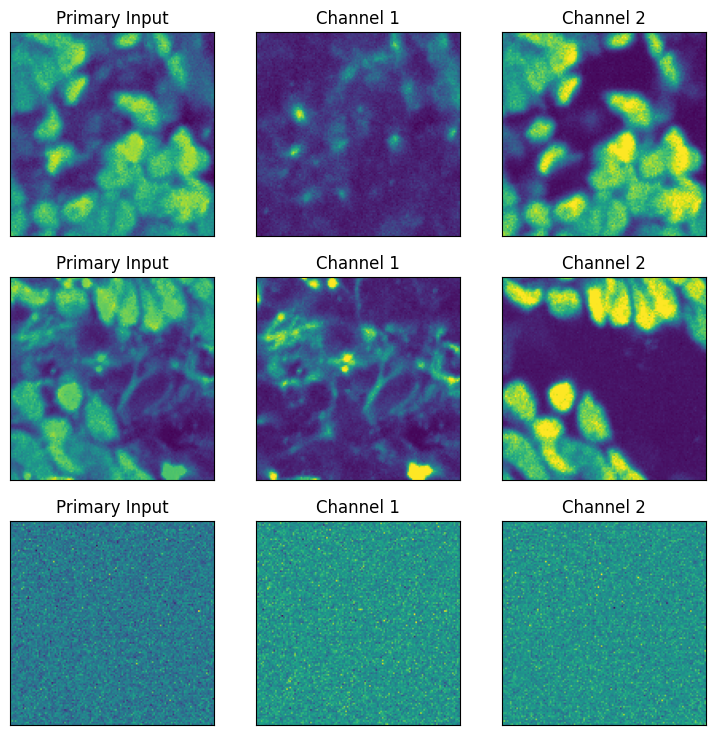

In [8]:
plot_input_patches_3d(dataset=dset, num_channels=2, num_samples=3, patch_size=128)

# **Step 2.2:** Picking <nobr>Micro$\mathbb{S}$plit</nobr> Model to Use

For all experiments we conducted for our paper, we offer you to download and use pretrained <nobr>Micro$\mathbb{S}$plit</nobr> networks. Let's check if a fitting model is available and download it.

In [9]:
MODEL_CHECKPOINTS = pooch.create(
    path=f"/group/jug/aman/Datasets/HT_H24/pretrained_checkpoints/",
    base_url=f"https://download.fht.org/jug/msplit/ht_h24/ckpts/",
    registry={f"best.ckpt": None},
)

pretrained_model_available = False
for f in MODEL_CHECKPOINTS.registry:
    if MODEL_CHECKPOINTS.is_available(f):
        MODEL_CHECKPOINTS.fetch(f"{f}", progressbar=True)
        pretrained_model_available = True

assert pretrained_model_available, "No suitable pretrained model for your data seems to be available.\nPlease train the model using the notebook '01_train.ipynb'."

100%|████████████████████████████████████████| 104M/104M [00:00<00:00, 137GB/s]


Let's see what model checkpoints you have available in the `checkpoints` folder, where the model(s) you trained with the notebook `01_train.ipynb` are stored, and the `pretrained_checkpoints` folder, where we just downloaded models into (as long as any such models exist on our servers).

In [10]:
from pathlib import Path

# Recursively search for .ckpt files in 'checkpoints' folder
ckpt_folder = Path("./checkpoints")
ckpt_folders = set()
for file in ckpt_folder.rglob("*.ckpt"):
    ckpt_folders.add(file.parent)
ckpt_folders = sorted(ckpt_folders)

# Recursively search for .ckpt files in 'pretrained_checkpoints' folder
pretrained_ckpt_folder = Path("./pretrained_checkpoints")
pretrained_ckpt_folders = set()
for file in pretrained_ckpt_folder.rglob("*.ckpt"):
    pretrained_ckpt_folders.add(file.parent)
pretrained_ckpt_folders = sorted(pretrained_ckpt_folders)

def list_available_model_checkpoint_folders():
    print('These models you have trained have been found:')
    if len(ckpt_folders)==0:
        print(' ❌ None!')
    else:
        for file in ckpt_folders:
            print(' 🟢', file)       
    if len(pretrained_ckpt_folders)==0:
        print(' ❌ None!')
    else:
        print('\nThese downloaded pretrained models have been found:')
        for file in pretrained_ckpt_folders:
            print(' 🟢', file)

## 👇 🤖 please pick one of the available models! 👇

In [11]:
list_available_model_checkpoint_folders()

These models you have trained have been found:

❌ None!

❌ None!

In [12]:
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
# if you cut&past a path to the chosen ckpt down here,
# we will use that checkpoint, otherwise we pick one automatically.
user_selected_ckpt_folder = 'pretrained_checkpoints'
# - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -

In [13]:
ckpt_folder = user_selected_ckpt_folder
if ckpt_folder == '':
    is_ckpt_auto_selected = True
    if len(pretrained_ckpt_folders) > 0:
        ckpt_folder = pretrained_ckpt_folders[0]
    if len(ckpt_folders) > 0: # prefer to use self-trained checkpoints
        ckpt_folder = ckpt_folders[0]
else:
    is_ckpt_auto_selected = False
    
if ckpt_folder=='':
    print("🚨 CRITICAL: No model checkpoint seems to be available!")
else:
    if is_ckpt_auto_selected:
        print("⚠️ Model checkpoint to be used was automatically selected!")
    selected_ckpt = load_checkpoint_path(str(ckpt_folder), best=True)
    print("✅ Selected model checkpoint:", selected_ckpt)

AssertionError: Invalid checkpoint path: pretrained_checkpoints

# **Step 2.3:** Prepare <nobr>Micro$\mathbb{S}$plit</nobr> Model
Next, we create all the configs needed to instatiate the selected model. These lines are not very intuitive and if you don't intend to dive really deep into CAREamics and the internals of <nobr>Micro$\mathbb{S}$plit</nobr>, you might just execute these cells and move on.

In [ ]:
experiment_params["data_stats"] = data_stats

# setting up model config (using default parameters)
model_config = get_model_config(**experiment_params)

In [ ]:
# making our data_stats known to the experiment (model) we prepare
experiment_params["data_stats"] = data_stats

# setting up model config (using default parameters)
model_config = get_model_config(**experiment_params)

# NOTE: The creation of the following configs are not strictly necessary for prediction,
#     but they ARE currently expected by the create_algorithm_config function below.
#     They act as a placeholder for now and we will work to remove them in a following release
loss_config = get_loss_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)

# finally, assemble the full set of experiment configurations...
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
)

### Create model and load checkpoint

In [ ]:
model = VAEModule(algorithm_config=experiment_config)

In [ ]:
from microsplit_reproducibility.notebook_utils.HT_H24 import load_pretrained_model
load_pretrained_model(model, selected_ckpt)

### Wanna be done quickly?
<div class="alert alert-block alert-info">
<b>Note:</b> Being quick will make the last notebook `03_calibration.ipynb` work less well. Still, if you just want to see some results the selected <nobr>Micro$\mathbb{S}$plit</nobr> model can generate, feel invited to crop down on the evaluation data we loaded above and save some time.
</div>

# TODO add desctiption how to reduce hw also

In [ ]:
reduce_data = False

if reduce_data:
    print("Using REDUCED evaluation data for quick'n'dirty testing!")
    dset.reduce_data(t_list=[0])
else:
    print('Using the full set of evaluation data!')
    print(f'(More specifically, I will use {dset.get_num_frames()} frames for evaluations.)') 

In [ ]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import dill
from usplit.core.tiff_reader import save_tiff
from careamics.lvae_training.eval_utils import stitch_and_crop_predictions_inner_tile_from_dir
from pathlib import Path

def get_save_dir(results_root):
    """
    Build save path as results_root/HT_LIF24/
    """
    save_dir = Path(results_root)
    save_dir.mkdir(parents=True, exist_ok=True)
    return save_dir

def get_raw_preds_dir(save_dir):
    """
    Build raw predictions folder under save_dir/raw_predictions_<exposure>_<checkpoint>
    """
    raw_dir = save_dir / f"raw_predictions_windowed"
    raw_dir.mkdir(parents=True, exist_ok=True)
    return raw_dir

# def run_inference_sliding(model, test_dset, results_root,
#                         batch_size=32, num_workers=4, dataset="HT_LIF24"):
#     """
#     Run model inference on the test dataset, predict all tiles, and save them as .npy files.
#     Does NOT check for existing predictions and does NOT stitch.
    
#     Args:
#         model: PyTorch model
#         test_dset: Dataset for inference
#         save_dir: Directory to save predictions (will be created if doesn't exist)
#         batch_size: Batch size for DataLoader
#         num_workers: Number of workers for DataLoader
#     """
#     print("Initialising")
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     model.eval().to(device)
#     save_dir = get_save_dir(results_root)
#     save_dir = Path(save_dir)
#     # fast_delete(save_dir)  # deletes folder and all files 
#     save_dir.mkdir(parents=True, exist_ok=True)

#     print("Loading Dataloader")
#     dloader = DataLoader(test_dset, pin_memory=True, num_workers=num_workers,
#                          shuffle=False, batch_size=batch_size)
#     print("Predicting now....")
#     global_idx = 0
#     with torch.no_grad():
#         for batch in tqdm(dloader, desc="Predicting tiles"):
#             inp = batch[0].to(device)
#             rec, _ = model(inp)

#             # get reconstructed img
#             if model.model.predict_logvar is None:
#                 rec_img = rec
#                 logvar = torch.tensor([-1])
#             else:
#                 rec_img, logvar = torch.chunk(rec, chunks=2, dim=1)

#             rec_np = rec_img.cpu().numpy()  # shape: (batch_size, C, H, W)
            
#             for i in range(rec_np.shape[0]):
#                 raw_pred_path = get_raw_preds_dir(save_dir)
#                 pred_path =  raw_pred_path / f"pred_{global_idx:010d}.npy"
#                 np.save(pred_path, rec_np[i])
#                 global_idx += 1
                
#     print(f"✅ Saved {global_idx} prediction tiles to {save_dir}")

    
# run_inference_sliding(
#     model,
#     dset,
#     results_root="results_ht_h24_sliding_windowed",
#     batch_size=64,
#     num_workers=6,
#     dataset="HT_H24",
# )


In [ ]:

def stitch_predictions_from_dir_only(
    train_dset,
    test_dset,
    results_root,
    dataset = "HT_H24",
    pred_dir_name=None,
    use_memmap=True,
    digits=10,
    batch_size=64,
    channels = 2,
):
    """
    Stitch raw predictions into a final image, without inference.
    """
    save_dir = get_save_dir(results_root)
    if pred_dir_name is None:
        raw_preds_dir = get_raw_preds_dir(save_dir)
    else:
        raw_preds_dir = Path(pred_dir_name)
    raw_preds_dir.mkdir(exist_ok=True, parents=True)

    print(f"📂 Reading raw predictions from: {raw_preds_dir}")

    stitched_predictions, counts = stitch_and_crop_predictions_inner_tile_from_dir(
        pred_dir=raw_preds_dir,
        dset=test_dset,
        num_workers=6,
        inner_fraction=0.5,
        num_patches = len(test_dset),
        batch_size=batch_size * 5,
        digits=digits,
        use_memmap=use_memmap,
        num_channels = channels,
        debug=False,
    )

    mean_params, std_params = dset.get_mean_std()
    stitched_predictions = stitched_predictions * std_params[
        "target"
    ].squeeze().reshape(1, 1, 1, 1, -1) + mean_params["target"].squeeze().reshape(
        1, 1, 1, 1, -1
    )

    with open(save_dir / "pred_test_dset_stitched.pkl", "wb") as f:
        dill.dump(stitched_predictions, f)
    save_tiff(save_dir / "pred_test_dset_stitched.tiff", stitched_predictions.transpose(0, 3, 1, 2))
    
    print(f"✅ Saved stitched predictions to {save_dir}")
    return stitched_predictions

stitched_predictions, counts = stitch_and_crop_predictions_inner_tile_from_dir(
        pred_dir=get_raw_preds_dir("/group/jug/aman/microsplit_runs_22Oct25/HT_H24/results_ht_h24_sliding_windowed"),
        dset=dset,
        num_workers=6,
        inner_fraction=0.5,
        num_patches = len(dset),
        batch_size=64
)


## Overview: visualize full <nobr>Micro$\mathbb{S}$plit</nobr> predictions...

In [ ]:
from microsplit_reproducibility.notebook_utils.HT_H24 import full_frame_evaluation

frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(norm_stitched_predictions[frame_idx], tar[frame_idx], z_idx=6)

## Detailed view on some (foreground) locations...
Below, we show few random foreground locations and the corresponding <nobr>Micro$\mathbb{S}$plit</nobr> predictions.

You can execute the cell multiple times and different randomly chosen locations will be plotted.

In [ ]:
from microsplit_reproducibility.utils.utils import clean_ax
from microsplit_reproducibility.notebook_utils.HT_H24 import pick_random_patches_with_content

img_sz = 128
rand_locations = pick_random_patches_with_content(tar, 128)
h_start = rand_locations[1, 0] #np.random.randint(stitched_predictions.shape[1] - img_sz)
w_start = rand_locations[1, 1] #np.random.randint(stitched_predictions.shape[2] - img_sz)

ncols = 4
nrows = min(len(rand_locations), 5) # we have 2 channels
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (z_idx, h_start, w_start) in enumerate(rand_locations[:nrows]):
    for ch in range(2):       
        for j in range(ncols//2):
            vmin = stitched_predictions[...,j].min()
            vmax = stitched_predictions[...,j].max()
            ax[i, j + ch].imshow(tar[0, z_idx, h_start:h_start+img_sz, w_start:w_start+img_sz, ch], vmin=vmin, vmax=vmax)
            ax[i, j + ch + 1].imshow(stitched_predictions[0, z_idx, h_start:h_start+img_sz, w_start:w_start+img_sz, ch], vmin=vmin, vmax=vmax)

ax[0, 0].set_title(f'Target Channel {1}')    
ax[0, 1].set_title(f'Predicted Channel {1}')
ax[0, 2].set_title(f'Target Channel {2}')
ax[0, 3].set_title(f'Predicted Channel {2}')


# reduce the spacing between the subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)
clean_ax(ax)

## *Optional:* manual inspection of the predictions
<div class="alert alert-block alert-info">
<b> Task:</b> Set <i>y_start</i>, <i>x_start</i>, and <i>crop_size</i> to inspect the predictions at a  location of your choice.
</div>

In [ ]:
import numpy as np

z_index = 4
y_start = 400  #np.random.randint(stitched_predictions.shape[1] - crop_size)
x_start = 700 #np.random.randint(stitched_predictions.shape[2] - crop_size)
crop_size = 256

ncols = 2
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))
for i in range(ncols):
    vmin = stitched_predictions[...,i].min()
    vmax = stitched_predictions[...,i].max()
    ax[0, i].imshow(tar[0, z_idx, y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)
    ax[1, i].imshow(stitched_predictions[0, z_idx, y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)

# disable the axis for ax[1,0]
ax[1,0].axis('off')
ax[0,0].set_title("Channel 1")
ax[0,1].set_title("Channel 2")
# set y labels on the right for ax[0,2]
ax[0,1].yaxis.set_label_position("right")
ax[0,1].set_ylabel("Target")

ax[1,1].yaxis.set_label_position("right")
ax[1,1].set_ylabel("Predicted")

print('Here the crop you selected:')

# ***Optional Step 2.5:*** Posterior Sampling and MMSE Predictions
For a given input patch, <nobr>Micro$\mathbb{S}$plit</nobr> can generate multiple outputs. This is possible because <nobr>Micro$\mathbb{S}$plit</nobr> is learning a full posterior of possible solutions, which is a quite powerful feature!

As we elaborate in the <nobr>Micro$\mathbb{S}$plit</nobr> paper and also later in the calibration notebook `03_calibration.ipynb`, this allows users to visually judge and even quantify the (data) uncertainty in the predictions their trained model makes.

Below, we show two posterior samples and how much they differ for a few random foreground locations. Re-run the cell to see different randomly choosen locations and corresponding posterior samples.

### Get two posterior samples and plot them...

In [ ]:
from microsplit_reproducibility.notebook_utils.HT_H24 import show_sampling

# Feel free to change this to see different slices
z_idx = 4 
imgsz = 3
ncols = 6
examplecount = 3
_, ax = plt.subplots(figsize=(imgsz*ncols, imgsz*2*examplecount), ncols=ncols, nrows=2*examplecount)

show_sampling(dset, model, ax=ax[:2], z_idx=z_idx)
show_sampling(dset, model, ax=ax[2:4], z_idx=z_idx)
show_sampling(dset, model, ax=ax[4:6], z_idx=z_idx)
plt.tight_layout()

### The MMSE solution and why you should care...
You might hae spotted a few tiling artefacts here and there in the plots above. This is mainly caused by the fact that we are using a variational model that predicts samples from the learned posterior.

Without going into all the details, at tile-edges, the posterior samples are simply not 100% consistent (because the input is subject to uncertainties due to non-perfect inputs).

Either way, without even telling you, the predictions you computed above are not single samples as the ones we saw in the previous plot. Instead, we have created multiple posterior samples and averaged them pixel by pixel.

***But why would we do that?*** While a single posterior sample is one interpretation of the noisy and likely somewhat ambiguous input data, the Minimum Mean Square Error (MMSE) of the posterior is the expected value of the posterior. Immagine it as the average of all posteror samples!

Fun fact, if you train a U-Net with an L2 loss, the U-Net's predictions will also be an approximation of the MMSE. 👀

Anyways, the details can be confusing... the take-home message is:
**The more posterior samples you average, the closer will this average image be at the MMSE solution. MMSE solutions look nice and smooth, and they are relatively consistent when we compute tiled predictions.

All this is certainly not obvious and if you are interested to learn more, maybe check out [this](https://arxiv.org/abs/2401.01438) and [this](https://openaccess.thecvf.com/content/ICCV2023/papers/Ashesh_uSplit_Image_Decomposition_for_Fluorescence_Microscopy_ICCV_2023_paper.pdf)!

But enough -- **let's compare single posterior samples with some approximate MMSE solutions**!

In [ ]:
import torch
# from tqdm.notebook import tqdm
from microsplit_reproducibility.notebook_utils.HT_H24 import pick_random_inputs_with_content

n_samples = 10
if n_samples < 5:
    n_samples = 5

# choose a random input patch
idx_list = pick_random_inputs_with_content(dset)
inp_patch, tar_patch = dset[idx_list[0]+1]

# compute individual posterior samples
samples = []
model.eval()

for _ in range(n_samples):
    with torch.no_grad():
        pred_patch,_ = model(torch.Tensor(inp_patch).unsqueeze(0).to(model.device))
        samples.append(pred_patch[0,:tar_patch.shape[0]].cpu().numpy())
samples = np.array(samples)

In [ ]:
inp_patch, tar_patch = dset[idx_list[0]]

z_idx = 4
nrows=5
imgsz=3

_,ax = plt.subplots(figsize=(imgsz*2,imgsz*nrows+imgsz), ncols=2, nrows=nrows)
ax[0,0].imshow(inp_patch[0][z_idx])
ax[0,0].set_title("Input (Idx: {})".format(idx_list[0]))

# first channel
ax[1,0].imshow(samples[0, 0][z_idx])
ax[1,0].set_title("C1: Sample")
ax[2,0].imshow(np.mean(samples[:5,0][:, z_idx], axis=0))
ax[2,0].set_title("C1: MMSE (5)")
ax[3,0].imshow(np.mean(samples[:,0][:, z_idx], axis=0))
ax[3,0].set_title(f"C1: MMSE ({len(samples)})")
ax[4,0].imshow(tar_patch[0][z_idx])
ax[4,0].set_title("C1: Target")

# second channel
ax[1,1].imshow(samples[0,1][z_idx])
ax[1,1].set_title("C2: Sample")
ax[2,1].imshow(np.mean(samples[:5,1][:, z_idx], axis=0))
ax[2,1].set_title("C2: MMSE (5)")
ax[3,1].imshow(np.mean(samples[:,1][:, z_idx], axis=0))
ax[3,1].set_title(f"C2: MMSE ({len(samples)})")
ax[4,1].imshow(tar_patch[1][z_idx])
ax[4,1].set_title("C2: Target")

ax[0,1].axis('off')

# **Step 2.6:** Quantitative Evaluation
For the *HT-H24* dataset, we have invested the extra effort to also image paired high-SNR data. In order to compute performance metrics that evaluate the quality of <nobr>Micro$\mathbb{S}$plit</nobr> predictions, we will use these high-SNR 'ground truth' images as references.

Let's first load this high-SNR data... and if necessary, download it before... 

In [ ]:
from microsplit_reproducibility.utils.paper_metrics import compute_high_snr_stats

print("Metric, followed by values for channel 1 and channel 2")
_ = compute_high_snr_stats(tar, stitched_predictions)

# **Step 2.7:** Saving data required for network calibration and error estimations (ie. for running `03_calibration.ipynb`)
We reached a point where we can train and use <nobr>Micro$\mathbb{S}$plit</nobr>. Only one key feature remains unexplored: the possibility to check how well calibrated a trained <nobr>Micro$\mathbb{S}$plit</nobr> network is, and then use multiple posterior samples to analyze their pixel-wise variability to ***estimate the true error*** with respect to unknown ground truth.

**Calibaration and error estimation will require:**<br>
***(i)*** target images as the one we used during training but for the *Test and Validation data* (we will store those in two files for later use),<br>
***(ii)*** saved MMSE predictions obtained with your trained model *on the Test and the Validation data* (also here we will store 2 files), and <br>
***(iii)*** saved pixel-wise standard deviations (Std) of the posterior samples we averaged to get the MMSE predictions from above (also on *Test and Validation data*, hence, yet another 2 files to be saved).

Once we created and saved all we need, the notebook `03_calibration.ipynb` does not have to deal with <nobr>Micro$\mathbb{S}$plit</nobr> models or predictions at all! 🥳

In [ ]:
# change this only if you used your own data
dataset_prefix = 'ht_h24_'

# create folder to store all the data (6 files in total) for the calibration notebook
path_for_calibration_data = "calibration_data"
os.makedirs(path_for_calibration_data, exist_ok=True)

### ***Step 2.7.1:*** Save target data we need in the calibration notebook.
We need the training-data like target channels later in the calibration notebook, and since we have this data availabe right here, let's quickly save it into the folder we created above (the one that will contain the 6 files we talk about all the time).

In [ ]:
data_stats = experiment_params["data_stats"]
target_val = val_dset._data[..., :-1]
target_test = test_dset._data[..., :-1]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 4, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 4, 1))

target_val_normalized  = (target_val  - sep_mean)/ sep_std
target_test_normalized = (target_test - sep_mean)/ sep_std

# store also the corresponding target data (this is just like the supervision data we used during training)
target_val_filename  = 'target_' + dataset_prefix + 'Val'
target_test_filename = 'target_' + dataset_prefix + 'Test'
tifffile.imwrite(
    f"{path_for_calibration_data}/{target_val_filename}.tif", target_val_normalized)
print(f'✅ Saved target data for Val data at "{path_for_calibration_data}/{target_val_filename}.tif"!')
tifffile.imwrite(
    f"{path_for_calibration_data}/{target_test_filename}.tif", target_test_normalized)
print(f'✅ Saved target data for Test data at "{path_for_calibration_data}/{target_test_filename}.tif"!')

### ***Step 2.7.2:*** Save the MMSE predictions and Std from Step 2.4.
Wee need four more things to have all the data for the calibration notebook together. More specifically, and as mentioned before, we need:
*(i)* the MMSE predictions for the Validation data, 
*(ii)* the MMSE predictions for the Test data,
*(iii)* the standard deviation (Std) of the posterior samples we drew to generate the MMSE predictions for the Validation data, and
*(iv)* the standard deviation (Std) of the posterior samples we drew to generate the MMSE predictions for the Test data.

Two of these four missing pieces we have computed above, depending on what you choose to work with, Validation or Training data (you made this choice in Step 2.1).
If you want to be prepared for the next notebook and haven't already, go back to Step 2.1, and set <i> evaluate_on_validation_data = True </i> and re-run the cells in the remainer of the notebook. Make sure `reduce_data` parameter setting is consistent. 

In [ ]:
# Let us make somewhat sure that this notebook is not in 'bad shape'
# (i) are the generated predictions of same shape?
assert norm_stitched_predictions.shape == stitched_stds.shape, "MMSE predictions and pixel-wise stds have incompatible shape. Please redo Step 2.4 of this notebook!"
# (ii) and is the high-SNR data loaded in Step 2.6 fitting inputs and predictions?
assert stitched_stds.shape == tar.shape, "Shape of predictions does not fit to shape of loaded inputs. Please check that the notebook is in a consistent sate!"

# check if user predicted on validation or test data
val_or_test = ('Val' if evaluate_on_validation_data else 'Test')

# print what we found for user
print(f'✅ Looks like predictions for {val_or_test} data were created above.\nWe will save those predictions in the next cell...')
the_other = ('Test' if evaluate_on_validation_data else 'Val')

In [ ]:
# store the predictions currently available in this notebook (created in Step 2.4 (predictions))
pred_filename = 'prediction_' + dataset_prefix + val_or_test
std_filename  = 'std_'        + dataset_prefix + val_or_test
tifffile.imwrite(
    f"{path_for_calibration_data}/{pred_filename}.tif", norm_stitched_predictions)
print(f'✅ Saved MMSE predictions for {val_or_test} data at "{path_for_calibration_data}/{pred_filename}.tif"!')
tifffile.imwrite(
    f"{path_for_calibration_data}/{std_filename}.tif", stitched_stds)
print(f'✅ Saved posterior sample Stds for {val_or_test} data at "{path_for_calibration_data}/{pred_filename}.tif"!')

print(f'\n‼️ Please ensure to also create and save these two files also for the {the_other} data!')
print(f'You are only ready for the calibration notebook once the folder "{path_for_calibration_data}" contain 6 files in total!')


**If 6 files (dataset name will differ) like the ones show below are in the above mentioned folder you are done here! 👍**
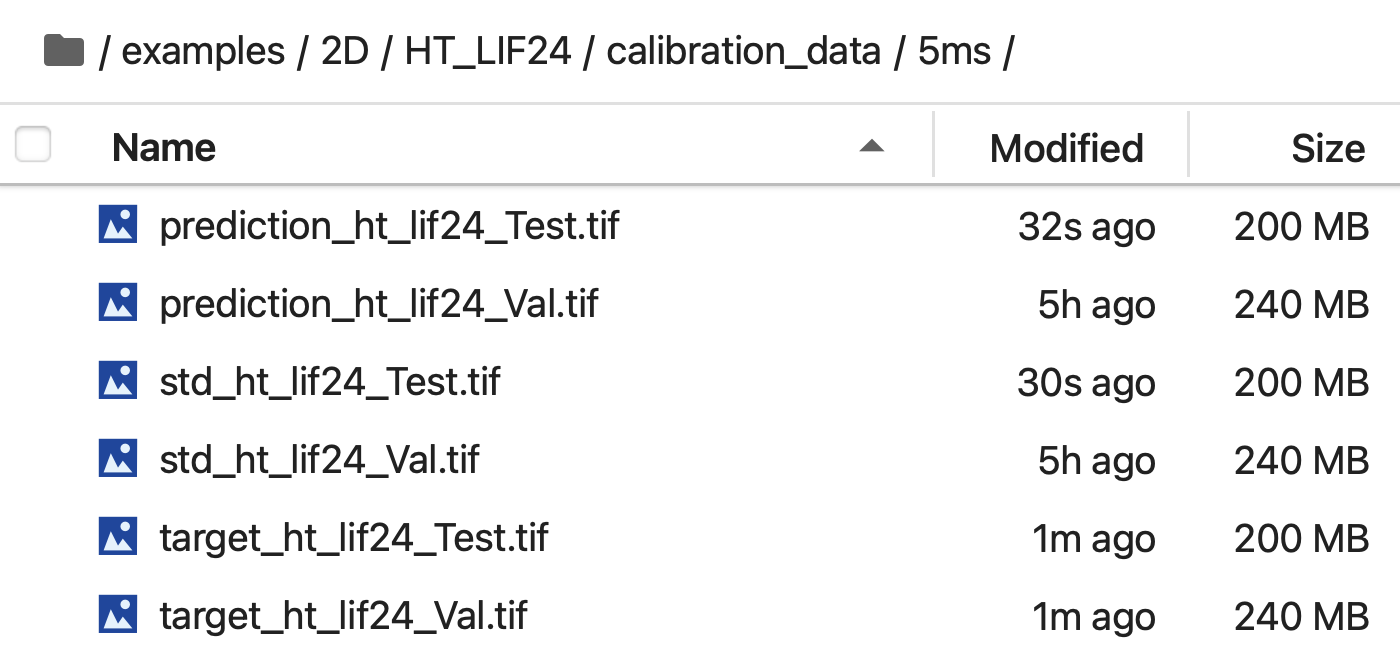
### Congratulations, done, that is fantastic! 🎉